In [ ]:
!pip install numpy==1.26.4
!pip install pandas
!pip install seaborn
!pip install torch
!pip install matplotlib
!pip install transformers
!pip install sklearn
!pip install datasets

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import collections

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset

print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
import logging
logging.getLogger("wandb").setLevel(logging.CRITICAL)

Device: cuda


In [ ]:
file_path = '/content/sample_data/Dataset_preprocess.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to confirm it's loaded
print(df.head())


   Label                                            Comment
0      0                               slayder gam cần_anh 
1      0                                      gam sẵn sèng 
2      0  sờ ty lè không_chỉ nhảy tường sờ ty lè nhảy ph...
3      0                                           mê nhảy 
4      0         chúc_mừng gam kỳ chuyển_nhượng thành_công 


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Label"])

MODEL_NAME = "vinai/bartpho-word"
NUM_CLASSES = len(pd.unique(df['Label']))
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)

def tokenize_function(batch):
    return tokenizer(batch['Comment'], truncation=True, padding="max_length", max_length=128)

def convert_to_numpy(batch):
    batch["input_ids"] = np.array(batch["input_ids"], dtype=np.int64)
    batch["attention_mask"] = np.array(batch["attention_mask"], dtype=np.int64)
    batch["Label"] = np.array(batch["Label"], dtype=np.int64)
    return batch

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of MBartForSequenceClassification were not initialized from the model checkpoint at vinai/bartpho-word and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_df["Label"] = train_df["Label"].astype(int)
test_df["Label"] = test_df["Label"].astype(int)

train_dataset = Dataset.from_pandas(train_df, preserve_index = False)
test_dataset = Dataset.from_pandas(test_df, preserve_index = False)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

#train_dataset = train_dataset.map(convert_to_numpy, batched=True)
#test_dataset = test_dataset.map(convert_to_numpy, batched=True)

train_dataset = train_dataset.rename_column("Label", "labels")
test_dataset = test_dataset.rename_column("Label", "labels")

Map:   0%|          | 0/11743 [00:00<?, ? examples/s]

Map:   0%|          | 0/2936 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if isinstance(logits, tuple):
        logits = logits[0]
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted")
    }

training_args = TrainingArguments(
    report_to="none",
    output_dir="./model/bartpho-word-finetuned",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.1,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-6-caea16d6ec24>:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.458100,0.350380,0.873297,0.866045,0.871063,0.873297
2,0.350500,0.345023,0.885218,0.882174,0.880119,0.885218


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight'].


TrainOutput(global_step=1468, training_loss=0.3689302553597848, metrics={'train_runtime': 2336.7125, 'train_samples_per_second': 10.051, 'train_steps_per_second': 0.628, 'total_flos': 6381138576256512.0, 'train_loss': 0.3689302553597848, 'epoch': 2.0})

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("./model/bartpho-word-finetuned/checkpoint-1468")
trainer = Trainer(model=model)
output = trainer.predict(test_dataset)

logits = output.predictions
y_true = output.label_ids

if isinstance(logits, tuple):
        logits = logits[0]
y_pred = np.argmax(logits, axis=-1)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9338    0.9592    0.9463      2280
           1     0.6685    0.6035    0.6343       401
           2     0.7328    0.6667    0.6982       255

    accuracy                         0.8852      2936
   macro avg     0.7784    0.7431    0.7596      2936
weighted avg     0.8801    0.8852    0.8822      2936



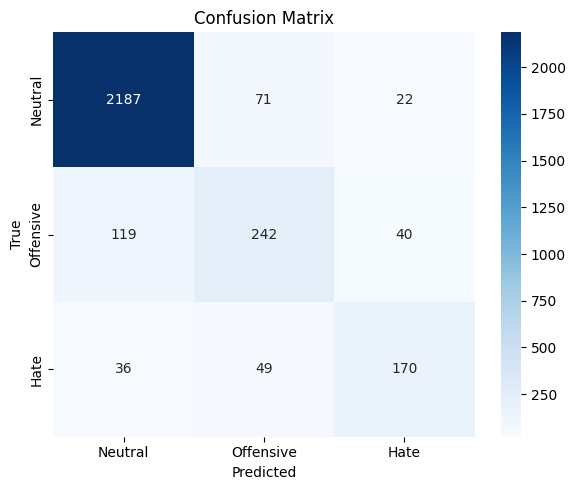

In [ ]:
cm = confusion_matrix(y_true, y_pred)
labels = ["Neutral", "Offensive", "Hate"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

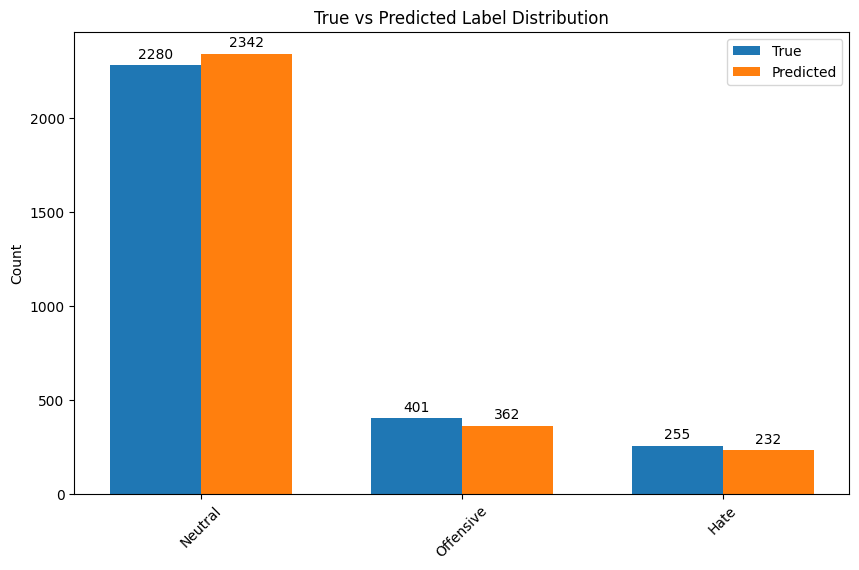

In [ ]:
true_counts = pd.Series(y_true).value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, true_counts, width, label='True')
bars2 = ax.bar(x + width/2, pred_counts, width, label='Predicted')

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylabel('Count')
ax.set_title('True vs Predicted Label Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()